In [ ]:
# In this notebook, we try to implement Sauvola block
# in PyTorch for "Retina Blood Vessel" dataset
#

In [ ]:
# imports
#
import sys
import os
import glob
import time
import numpy as np
import scipy as sp
import skimage
from skimage import segmentation, io, filters, morphology
import sklearn
from sklearn import ensemble, metrics, svm
import matplotlib.pyplot as plt

import torch, torchvision

from IPython.core.debugger import set_trace

In [ ]:
# Globals
#
train_image_ipath = 'RetinaBloodVessels/train/image/'
train_mask_ipath = 'RetinaBloodVessels/train/mask/'
test_image_ipath = 'RetinaBloodVessels/test/image/'
test_mask_ipath = 'RetinaBloodVessels/test/mask/'
NROWS, NCOLS = 512, 512
EPSILON = 1e-6
br = breakpoint

In [ ]:
# functions and classes

def read_images(path, rescale=True):
    images_fnames = sorted(glob.glob(os.path.join(path, '*.png')))
    images = []
    for fn in images_fnames:
        img = io.imread(fn)
        if rescale:
            img = np.uint32(img)/255
        images.append(img)
    images = np.array(images)
    return images

def gray(img):
    gr = img.mean(axis=2)
    gr = (gr - gr.min()) / (gr.max() - gr.min() + EPSILON)
    return gr

def show(img):
    if img.max != 255:
        img = np.float64(img)
        img = np.uint8(255*(img - img.min())/(img.max()-img.min() + EPSILON))
    fig = plt.figure(figsize=(5, 5))
    ax = fig.subplots()
    ax.imshow(img, cmap='gray')
    return True

def filters(image):
    """
    adds filtered dimensions to the main image.
    image should be 2D
    """
    filts = [[3, 1e-1], [3, 1e-2], [3, 1e-3],
             [5, 1e-2], [5, 1e-2], [5, 1e-3],
             [7, 1e-1], [7, 1e-2], [7, 1e-3]]
    images = np.zeros(image.shape + (len(filts) + 1, ))
    images[:, :, 0] = image
    for fc, filt in enumerate(filts):
        bw = image > skimage.filters.threshold_sauvola(
            image, window_size=filt[0], k=filt[1], r=None)
        images[:, :, fc+1] = bw * (image > 0.2)
    return images

def feat_targ(images, mask):
    """images: all filtered version of the original image with
               the shape of (nrows, ncols, nfilters)
    """
    ft = []
    nrows, ncols = tuple(images.shape[:2])
    iml = images.tolist()
    for rc in range(nrows):
        for cc in range(ncols):
            ft.append(iml[rc][cc] +  [mask[rc, cc]])
    return np.array(ft)


class SauvolaBlock(torch.nn.Module):
    def __init__(self, kernel_size=1, k=0.1):
        super().__init__()
        # aggregation
        self.conv = torch.nn.Conv2d(in_channels=1, out_channels=1, 
                                    kernel_size=kernel_size, stride=1, 
                                    padding='same',
                                    bias=False)
        self.k = k
        # self.conv.weight = self.conv.weight.requires_grad_(False)
        self.kernel_size = kernel_size
        weight = torch.ones_like(self.conv.weight)
        # weight /= weight.sum()
        self.conv.weight = torch.nn.parameter.Parameter(weight, requires_grad=False)
    def forward(self, img):
        # set_trace()
        x = self.conv(img)
        # print(x.min(), x.max())
        xmean = x / self.kernel_size**2
        # xvar = 1.0 * (torch.abs(img - xmean) > 5e-3)
        xvar = self.conv((img - xmean)**2)
        xvar = xvar / self.kernel_size**2
        # Sauvola threshold
        st = xmean * (1 + self.k*(xvar / xvar.max() - 1))
        return xmean, xvar, st

# Moment Block
class Moment(torch.nn.Module):
    def __init__(self, neighbor=1, order=1):
        super().__init__()
        self.neighbor = neighbor
        self.order = order
        # aggregation
        self.conv = torch.nn.Conv2d(in_channels=1, out_channels=1, 
                                    kernel_size=neighbor, stride=1, 
                                    padding='same',
                                    bias=False)
        weight = torch.ones_like(self.conv.weight)
        # weight /= weight.sum()
        self.conv.weight = torch.nn.parameter.Parameter(weight, requires_grad=False)
        
    def forward(self, x):
        square = self.neighbor**2
        xmean = self.conv(x) / square
        std = (self.conv((x - xmean)**2) / square)**0.5
        z = (x - xmean) / (std + EPSILON)
        moment = self.conv(z**self.order) / square
        return moment

# Filter Bank Block
class FilterBank(torch.nn.Module):
    def __init__(self, neighbor=1, order=1):
        super().__init__()
        self.neighbor = neighbor
        self.order = order
        # aggregation
        self.conv = torch.nn.Conv2d(in_channels=1, out_channels=1, 
                                    kernel_size=neighbor, stride=1, 
                                    padding='same',
                                    bias=False)
        weight = torch.ones_like(self.conv.weight)
        # weight /= weight.sum()
        self.conv.weight = torch.nn.parameter.Parameter(weight, requires_grad=False)
        
    def forward(self, x):
        square = self.neighbor**2
        xmean = self.conv(x) / square
        std = (self.conv((x - xmean)**2) / square)**0.5
        z = (x - xmean) / (std + EPSILON)
        moment = self.conv(z**self.order) / square
        return moment

(512, 512) -1.2766682 1.2090478


True

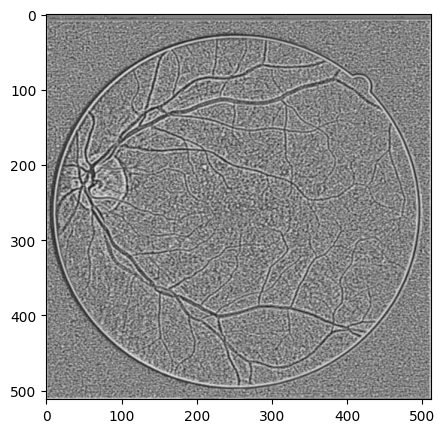

In [419]:
mt = Moment(neighbor=3, order=1)
img = np.array(gr)
moment = mt(torch.Tensor(img).unsqueeze(dim=0))
moment = moment.numpy().squeeze()
print(moment.shape, moment.min(), moment.max())
# show(gr)
show(moment)

In [390]:
(-5)**(1/3)

(0.8549879733383486+1.480882609682364j)

In [ ]:
# read all images and masks and store in two matrices
train_images = read_images(train_image_ipath)
train_masks = np.int64(read_images(train_mask_ipath, rescale=False) > 0)
test_images = read_images(test_image_ipath)
test_masks = np.int64(read_images(test_mask_ipath, rescale=False) > 0)
print(train_images.shape, train_masks.shape,
      test_images.shape, test_masks.shape)

True

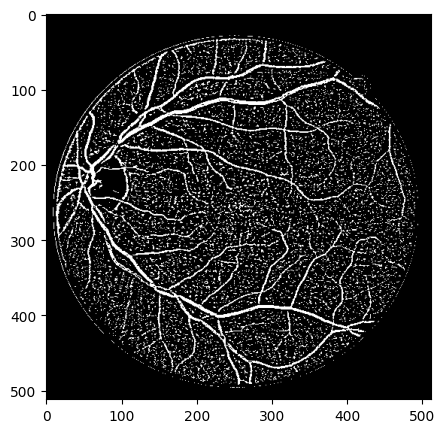

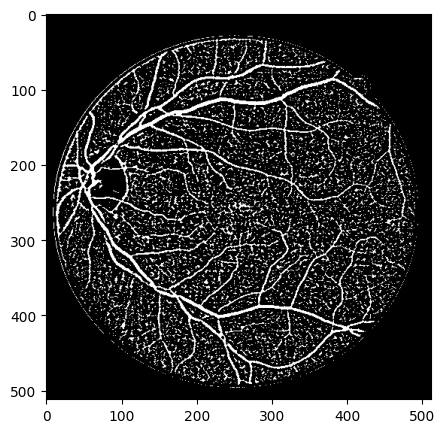

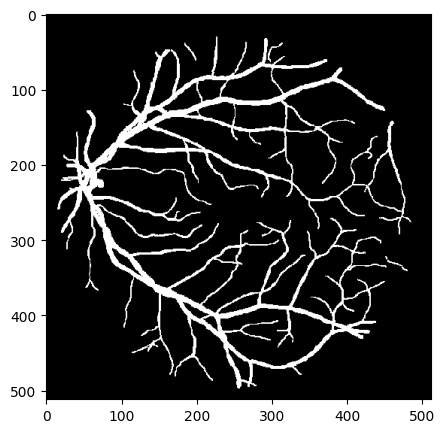

In [311]:
# sauvola
#
image = train_images[0, :, :, :]
mask = train_masks[0, :, :]
gr = gray(image)
trsh = skimage.filters.threshold_sauvola(
    gr, window_size=7, k=15e-3, r=None)
bw = (1 - (gr > trsh)) * (gr >= 0.2)

pp = skimage.morphology.binary_closing(
    bw, footprint=morphology.disk(1))

# pp = skimage.morphology.binary_opening(
#     bw, footprint=morphology.disk(1)) #footprint=np.ones((7, 7)))

# pp = skimage.morphology.binary_erosion(
#     bw, footprint=np.ones((2, 2))) #, footprint=morphology.disk(1))

# med = filters.median(bw, footprint=morphology.disk(3))

# show(gr)
show(bw)
show(pp)
show(mask)

True

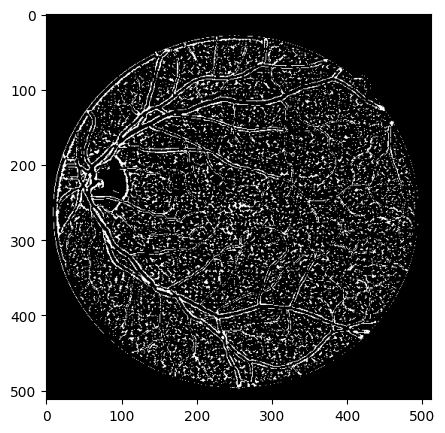

In [210]:
show(1.0 * (pp != mask))

In [192]:
imgs = filters(gr)

True

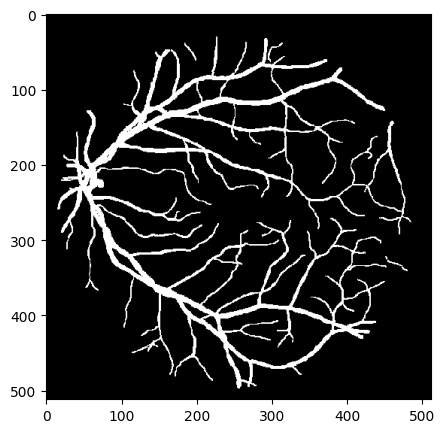

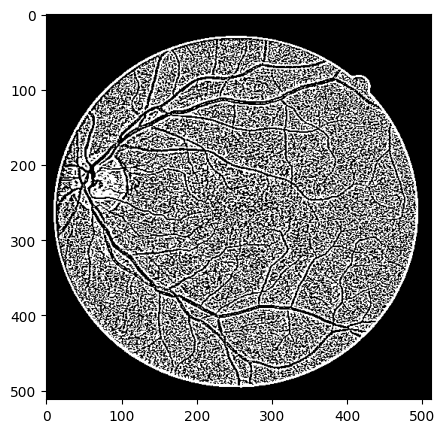

In [193]:
show(mask)
show(imgs[:, :, 6])

In [194]:
ft = feat_targ(imgs, mask)

In [195]:
ft.shape

(262144, 11)

0.8987655639648438


True

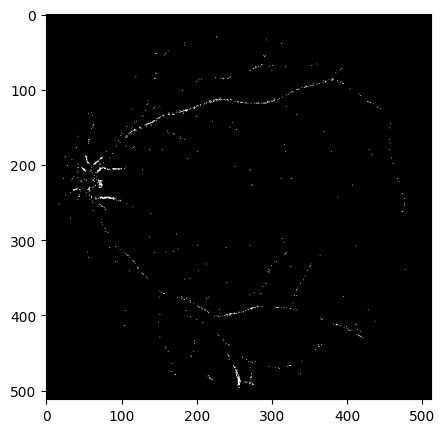

In [203]:
# classification
rf = ensemble.RandomForestClassifier(
    100, class_weight={0: 100, 1: 1}).fit(ft[:, :-1], ft[:, -1])
tr_detect = rf.predict(ft[:, :-1])
print(metrics.accuracy_score(mask.flatten(), tr_detect))
show(tr_detect.reshape(NROWS, NCOLS))

In [ ]:
# classification
sv = svm.SVC().fit(ft[:, :-1], np.uint64(ft[:, -1]))
tr_detect = sv.predict(ft[:, :-1])
print(metrics.accuracy_score(np.uint64(mask.flatten()), np.uint64(tr_detect)))
show(tr_detect.reshape(NROWS, NCOLS))

In [200]:
np.unique(tr_detect)

array([0., 1.])